### Generate Differential Graph from Senate Voting Data

In [2]:
# %%

import torch 
import matplotlib.pyplot as plt

import numpy as np

def g(t):
    return -(t-1)*t

def dg(t):
    return -2*t+1

def f(x):
    n, d, nt = x.shape
    pairwise_features = torch.zeros((n, d * (d + 1) // 2, nt))
    
    idx = 0
    for i in range(d):
        for j in range(i, d):
            pairwise_features[:, idx, :] = x[:, i, :] * x[:, j, :]
            idx += 1
            
    return pairwise_features


def phi(fXqt, t, sigma = .05):
    Kt = torch.exp(-(t[:, None] - t[:, None].T)**2/sigma**2/2)
    Eqtfx = fXqt[0, :, :] @ Kt / torch.sum(Kt, 1)
    print(Eqtfx.shape)
    return fXqt - Eqtfx

In [3]:
# %%

def train(X, t, lmbd = .001):
    phiXqt = phi(f(X), t).squeeze().transpose(1, 0)
    fXqt = f(X).squeeze().transpose(1, 0)

    n = phiXqt.shape[0]
    d = phiXqt.shape[1]
    
    A = phiXqt.T @ torch.diag(g(t)) @ phiXqt / n
    b = dg(t) @ fXqt / n
    b = b[:, None]
    
    alpha_hat = torch.zeros(d, 1)
    
    def proximal_operator_l1(v, alpha):
        return np.sign(v) * np.maximum(np.abs(v) - alpha, 0)

    def proximal_gradient_descent(Q, c, lambd, x0, lr, max_iter):
        x = x0.copy()
        for i in range(max_iter):
            gradient = Q @ x + c
            x = x - lr * gradient
            x = proximal_operator_l1(x, lr * lambd)
            
            print(f"Iteration {i}: gradient norm = {np.linalg.norm(gradient)}")
        return x
    
    sol = proximal_gradient_descent(A.detach().numpy(), 
                                    b.detach().numpy(), 
                                    lmbd, alpha_hat.detach().numpy(), 0.01, 10000)
    return torch.tensor(sol)

In [4]:
# %%

torch.manual_seed(2)

import pandas as pd

# Step 1: Load CSV using pandas
df = pd.read_csv('senate109/data_senate_global.csv')

header = df.columns
data = df.to_numpy()
votes = torch.tensor(data, dtype=torch.float32)

votes = votes[:, 1:]
votes = votes[6262:6689] # only select the 109th senate

# Step 1: Load the CSV file
df = pd.read_csv('senate109/dates_senate_global.csv', usecols=["x"])  # Load only the "x" column

# Step 2: Convert the dates to datetime format
df['x'] = pd.to_datetime(df['x'])

# Step 3: Convert the dates to a numeric format (timestamps)
timestamps = df['x'].astype('int64') // 10**9  # UNIX timestamp in seconds

# Step 4: Rescale the timestamps between 0 and 1
min_timestamp = timestamps.min()
max_timestamp = timestamps.max()
scaled_values = (timestamps - min_timestamp) / (max_timestamp - min_timestamp)

# Step 5: Replace the original column with the scaled values
df['scaled_x'] = scaled_values

t = torch.tensor(df['scaled_x'].to_numpy(), dtype=torch.float32)
t = t[6262:6689]

# Step 1: Load the CSV file
df = pd.read_csv("senate109/data14_proc.csv", header=0)  # Read CSV with the first row as header

# Step 2: Extract the first column as 'names'
names = df.iloc[:, 0]  # This selects the first column

# Step 3: Apply string operations (strip, lowercase, titlecase)
formatted_names = names.str.strip().str.lower().str.title()
formatted_names = formatted_names.tolist()

# read senate109/name.csv with no header
df = pd.read_csv('senate109/name.csv', header=None)
# convert the first column to a list
names = df[0].tolist()

df = pd.read_csv('senate109/party.csv', header=None)
parties = df[0].tolist()

# for each formatted name, find the corresponding name in the list of names, 
# regardless the capitalization,
# and get the party of that senator

party_affiliations = []
for name in formatted_names:
    for i, n in enumerate(names):
        if name.lower() in n.lower():
            party_affiliations.append(parties[i])
            break

C:\Users\sl9885\AppData\Local\Temp\ipykernel_41364\3327079413.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [28]:
# %%

Xqt = votes.T[None, :, :]

d = Xqt.shape[1]
nt = Xqt.shape[0]

print('training model...')
alpha_hat = train(Xqt, t, lmbd= 1e-1 * 1.7)

training model...
torch.Size([5050, 427])
Iteration 0: gradient norm = 13.403916358947754
Iteration 1: gradient norm = 13.068605422973633
Iteration 2: gradient norm = 12.889647483825684
Iteration 3: gradient norm = 12.713006019592285
Iteration 4: gradient norm = 12.533794403076172
Iteration 5: gradient norm = 12.358589172363281
Iteration 6: gradient norm = 12.190979957580566
Iteration 7: gradient norm = 12.032100677490234
Iteration 8: gradient norm = 11.882084846496582
Iteration 9: gradient norm = 11.740610122680664
Iteration 10: gradient norm = 11.607270240783691
Iteration 11: gradient norm = 11.481592178344727
Iteration 12: gradient norm = 11.363007545471191
Iteration 13: gradient norm = 11.251002311706543
Iteration 14: gradient norm = 11.144990921020508
Iteration 15: gradient norm = 11.044652938842773
Iteration 16: gradient norm = 10.949555397033691
Iteration 17: gradient norm = 10.859457969665527
Iteration 18: gradient norm = 10.774059295654297
Iteration 19: gradient norm = 10.6930

tensor([[3.6557, 0.0000, 0.0000,  ..., -0.0000, 0.0000, 0.1762],
        [0.0000, 0.0000, 0.0000,  ..., -0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., -0.0000, 0.0000, 0.0000],
        ...,
        [-0.0000, -0.0000, -0.0000,  ..., 0.0000, -0.0000, -0.0000],
        [0.0000, 0.0000, 0.0000,  ..., -0.0000, 0.0000, 0.0000],
        [0.1762, 0.0000, 0.0000,  ..., -0.0000, 0.0000, 2.6995]])


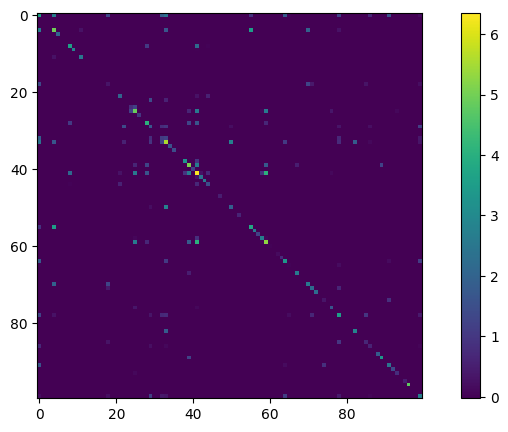

tensor(73.)


In [29]:
#%%

Theta = torch.zeros(d, d)
idx = 0
for i in range(d):
    for j in range(i, d):
        Theta[i, j] = alpha_hat[idx]
        Theta[j, i] = alpha_hat[idx]
        idx += 1

print(Theta)

# plot two image side by side, one is the true graph, the other is the estimated graph
plt.figure(figsize=(10, 5))
plt.imshow(Theta.detach().numpy())
plt.colorbar()
plt.show()

Theta.fill_diagonal_(0)
# total number of detected edges
print(torch.sum(torch.abs(Theta) > 1e-6)/2)

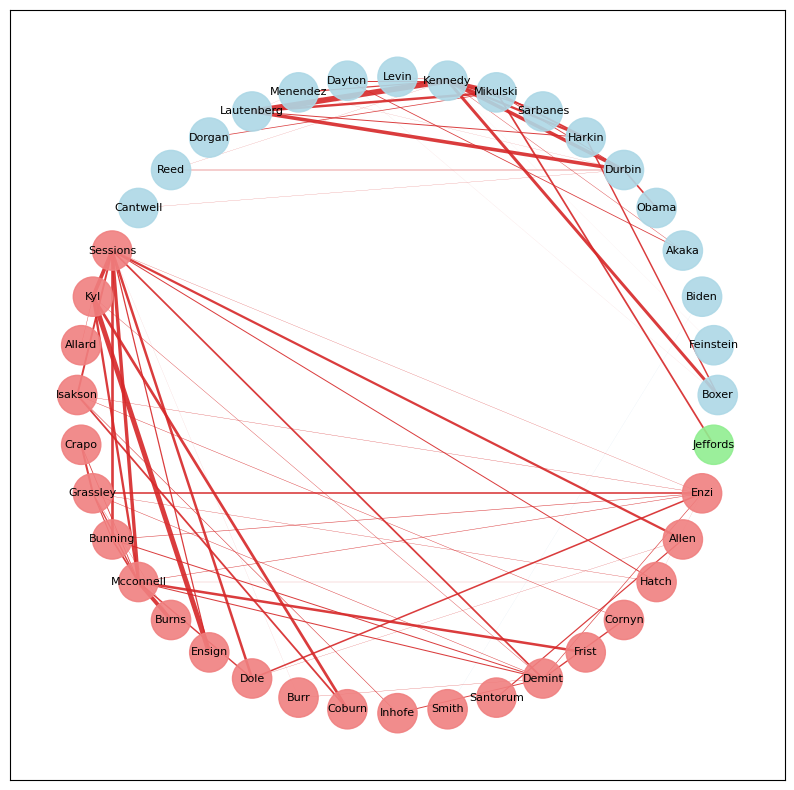

In [30]:
# %% draw diagram of the graph using Theta, and the names of the senators

import networkx as nx
import matplotlib.pyplot as plt

democrats = [i for i, party in enumerate(party_affiliations) if party == 1]
republicans = [i for i, party in enumerate(party_affiliations) if party == -1]
independents = [i for i, party in enumerate(party_affiliations) if party == 0]

ordered_nodes = democrats + republicans + independents


G = nx.Graph()
# add nodes
for new_index, original_index in enumerate(ordered_nodes):
    G.add_node(new_index, name=formatted_names[original_index], party=party_affiliations[original_index])

# add edges
for i in range(d):
    for j in range(i + 1, d):
        if torch.abs(Theta[i, j]) > 1e-6:
            reordered_i = ordered_nodes.index(i)
            reordered_j = ordered_nodes.index(j)
            G.add_edge(reordered_i, reordered_j, weight=Theta[i, j])
            G.add_edge(reordered_j, reordered_i, weight=Theta[j, i])

# Remove nodes that do not have any edges (isolated nodes)
isolated_nodes = list(nx.isolates(G))  # Find all nodes without edges
G.remove_nodes_from(isolated_nodes)    # Remove those nodes

# Get the node labels (from the 'name' attribute)
labels = nx.get_node_attributes(G, 'name')

# Extract edge weights for setting edge thickness
weights = [G[u][v]['weight'] for u, v in G.edges()]
colors = ['tab:red' if w > 0 else 'tab:blue' for w in weights]  # Red for positive, Blue for negative

colormap = []
for node in G:
    if G.nodes[node]['party'] == 1:
        # light blue
        colormap.append('lightblue')
    elif G.nodes[node]['party'] == -1:
        # ligth red
        colormap.append('lightcoral')
    else:
        # light green
        colormap.append('lightgreen')
        
# draw the graph
plt.figure(figsize=(10, 10))
# pos = nx.spectral_layout(G, scale=.1)
# pos = nx.spring_layout(G, k = .25)
pos = nx.circular_layout(G)
# pos = nx.multipartite_layout(G, subset_key='party', align='horizontal')


options = {"node_size": 800, "alpha": .9}
# draw node, edge and labels separately
nx.draw_networkx_nodes(G, pos, node_color=colormap, **options)

nx.draw_networkx_edges(G, pos, edge_color=colors, width=weights, **options)
nx.draw_networkx_labels(G, pos, labels, font_size=8)

plt.show()